In [60]:
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [61]:
from datasets import load_dataset

dataset = load_dataset("food101")

In [62]:
### Dataset Information ###
print("### Dataset Information ###\n")
print("Number of training images: ", len(dataset["train"]))
print("Number of labels: ", len(dataset["train"].features["label"].names))

### Dataset Information ###

Number of training images:  75750
Number of labels:  101


In [63]:
id2label = {}
for i, label in enumerate(dataset["train"].features["label"].names):
  id2label[i] = label

In [64]:
id2label

{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare',
 5: 'beet_salad',
 6: 'beignets',
 7: 'bibimbap',
 8: 'bread_pudding',
 9: 'breakfast_burrito',
 10: 'bruschetta',
 11: 'caesar_salad',
 12: 'cannoli',
 13: 'caprese_salad',
 14: 'carrot_cake',
 15: 'ceviche',
 16: 'cheesecake',
 17: 'cheese_plate',
 18: 'chicken_curry',
 19: 'chicken_quesadilla',
 20: 'chicken_wings',
 21: 'chocolate_cake',
 22: 'chocolate_mousse',
 23: 'churros',
 24: 'clam_chowder',
 25: 'club_sandwich',
 26: 'crab_cakes',
 27: 'creme_brulee',
 28: 'croque_madame',
 29: 'cup_cakes',
 30: 'deviled_eggs',
 31: 'donuts',
 32: 'dumplings',
 33: 'edamame',
 34: 'eggs_benedict',
 35: 'escargots',
 36: 'falafel',
 37: 'filet_mignon',
 38: 'fish_and_chips',
 39: 'foie_gras',
 40: 'french_fries',
 41: 'french_onion_soup',
 42: 'french_toast',
 43: 'fried_calamari',
 44: 'fried_rice',
 45: 'frozen_yogurt',
 46: 'garlic_bread',
 47: 'gnocchi',
 48: 'greek_salad',
 49: 'grilled_chees

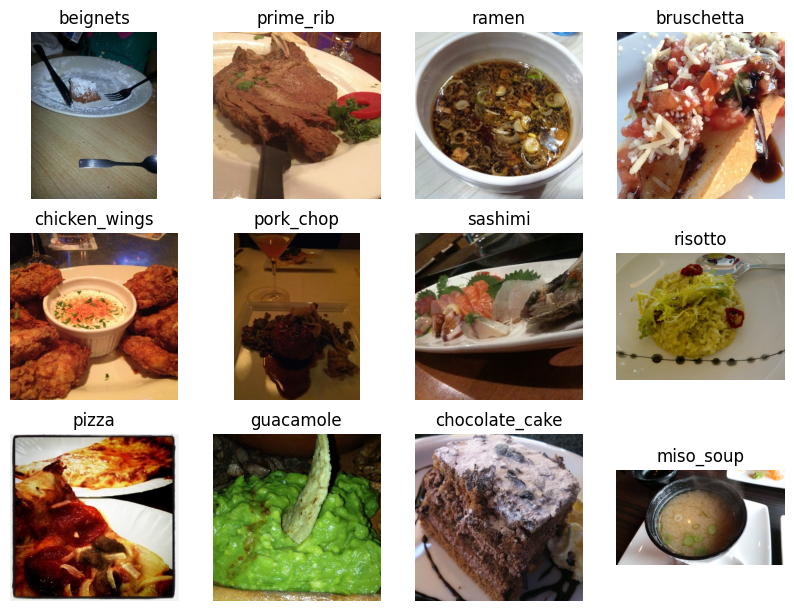

In [65]:
rows = 4; cols = 4
fig = plt.figure(figsize=(10, 10))
c = 0
for i in range(0, 12000, 1000):
  ax = fig.add_subplot(rows, cols, c+1)
  image = dataset["train"][i]["image"]
  plt.imshow(image)
  plt.axis('off')
  plt.title(id2label[dataset["train"][i]["label"]])
  c+=1
plt.show()

In [66]:
import open_clip

In [67]:
model_name = 'RN50-quickgelu'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained='openai')
tokenizer = open_clip.get_tokenizer(model_name)

100%|███████████████████████████████████████| 256M/256M [01:23<00:00, 3.07MiB/s]


In [72]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [73]:
# subset dataset
num_samples = 1000
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [74]:
dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 75750
})

In [75]:
def extract_embeddings(model: torch.nn.Module):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    def extract(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [preprocess(image).cuda() for image in images]
        )
        new_batch = image_batch_transformed.to(device)
        with torch.no_grad():
            embeddings = model.encode_image(image_batch_transformed)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)
        return {"embeddings": embeddings}

    return extract

In [76]:
x = candidate_subset['image'][0]

In [77]:
extract_fn = extract_embeddings(model.cuda())

In [78]:
X = preprocess(x)

In [79]:
X

tensor([[[-1.7485, -1.7339, -1.7485,  ..., -0.7996, -0.7558, -0.7558],
         [-1.7777, -1.7777, -1.7923,  ..., -0.7704, -0.7704, -0.7850],
         [-1.6463, -1.6609, -1.7047,  ..., -0.7850, -0.7704, -0.7996],
         ...,
         [-0.9018, -0.7120, -0.1426,  ...,  0.2515,  0.2077,  0.1931],
         [-0.4638,  0.1493,  0.4851,  ...,  0.2223,  0.1931,  0.1931],
         [ 0.3537,  0.5435,  0.5581,  ...,  0.2223,  0.2077,  0.2223]],

        [[-1.6621, -1.6771, -1.7071,  ..., -0.5815, -0.6265, -0.6265],
         [-1.6921, -1.7071, -1.7521,  ..., -0.5665, -0.6265, -0.6565],
         [-1.4669, -1.4820, -1.5270,  ..., -0.5815, -0.6265, -0.6715],
         ...,
         [-0.9867, -0.7466, -0.1463,  ...,  0.3940,  0.3490,  0.3490],
         [-0.5215,  0.1839,  0.5441,  ...,  0.3640,  0.3340,  0.3490],
         [ 0.3490,  0.6191,  0.6642,  ...,  0.3640,  0.3490,  0.3640]],

        [[-1.4802, -1.4802, -1.4802,  ..., -0.3284, -0.3711, -0.3995],
         [-1.4376, -1.4233, -1.4660,  ..., -0

In [80]:
X.cuda()

tensor([[[-1.7485, -1.7339, -1.7485,  ..., -0.7996, -0.7558, -0.7558],
         [-1.7777, -1.7777, -1.7923,  ..., -0.7704, -0.7704, -0.7850],
         [-1.6463, -1.6609, -1.7047,  ..., -0.7850, -0.7704, -0.7996],
         ...,
         [-0.9018, -0.7120, -0.1426,  ...,  0.2515,  0.2077,  0.1931],
         [-0.4638,  0.1493,  0.4851,  ...,  0.2223,  0.1931,  0.1931],
         [ 0.3537,  0.5435,  0.5581,  ...,  0.2223,  0.2077,  0.2223]],

        [[-1.6621, -1.6771, -1.7071,  ..., -0.5815, -0.6265, -0.6265],
         [-1.6921, -1.7071, -1.7521,  ..., -0.5665, -0.6265, -0.6565],
         [-1.4669, -1.4820, -1.5270,  ..., -0.5815, -0.6265, -0.6715],
         ...,
         [-0.9867, -0.7466, -0.1463,  ...,  0.3940,  0.3490,  0.3490],
         [-0.5215,  0.1839,  0.5441,  ...,  0.3640,  0.3340,  0.3490],
         [ 0.3490,  0.6191,  0.6642,  ...,  0.3640,  0.3490,  0.3640]],

        [[-1.4802, -1.4802, -1.4802,  ..., -0.3284, -0.3711, -0.3995],
         [-1.4376, -1.4233, -1.4660,  ..., -0

In [82]:
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model)
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map: 100%|██████████| 1000/1000 [00:06<00:00, 143.70 examples/s]


In [83]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["label"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

print("Sample first indexing: ", candidate_ids[0])

100%|██████████| 1000/1000 [00:01<00:00, 682.81it/s]

Sample first indexing:  0_74


In [84]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings).double()

print("Check embedding shape: ", all_candidate_embeddings.shape)

Check embedding shape:  torch.Size([1000, 1024])


In [104]:

prompt = "Sashimi"
text = tokenizer([prompt]).cuda()
text_feature = model.encode_text(text)
text_feature /= text_feature.norm(dim=-1, keepdim=True)
text_feature = text_feature.type(torch.DoubleTensor)

print("Check text feature shape: ", text_feature.shape)

Check text feature shape:  torch.Size([1, 1024])


In [105]:
def fetch_clip_similar(features, top_k=5):
  similarity = (100 * all_candidate_embeddings @ features.T ).softmax(dim=0)

  search_result = {}
  for i, sim in enumerate(similarity.detach().numpy()):
    search_result[candidate_ids[i]] = sim[0]
  similarity_mapping_sorted = dict(sorted(search_result.items(),
                                          key=lambda x: x[1],
                                          reverse=True))
  id_entries = list(similarity_mapping_sorted.keys())[:top_k]

  ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
  labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
  return ids, labels

In [106]:
sim_text_ids, sim_text_labels = fetch_clip_similar(text_feature)
print(f"Query prompt: {prompt}")
print(f"Top 5 candidate labels: {sim_text_labels}")

Query prompt: Sashimi
Top 5 candidate labels: [86, 86, 86, 86, 86]


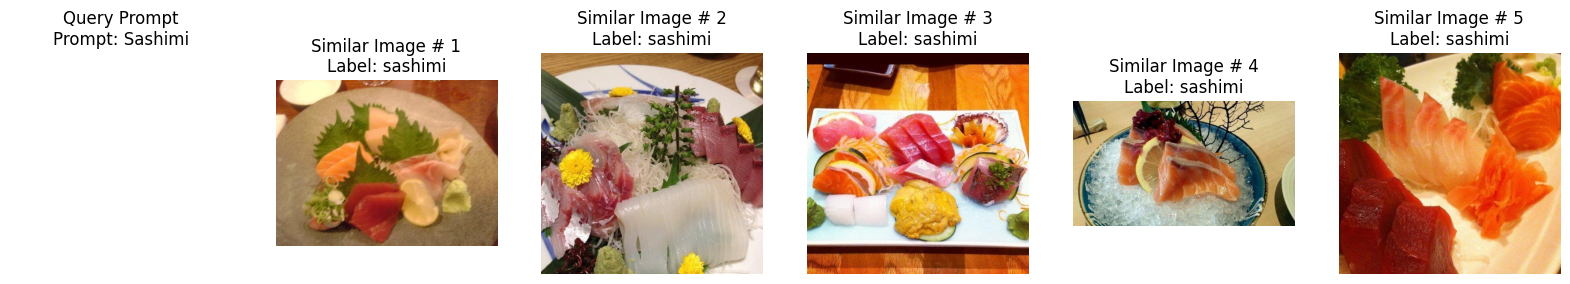

In [107]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = labels[i]
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Prompt\n" + f"Prompt: {label_id}")
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[int(label_id)])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

images = []
labels = []

for id, label in zip(sim_text_ids, sim_text_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

test_sample = np.zeros([100,100,3], dtype=np.uint8); test_sample.fill(255)
images.insert(0, test_sample)
labels.insert(0, prompt)
plot_images(images, labels)

Search for -  bruschetta


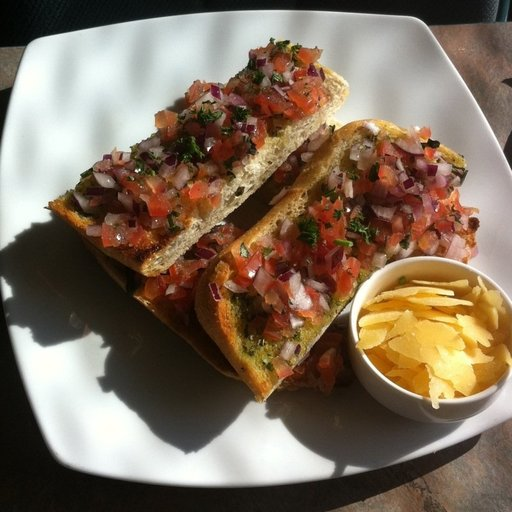

In [98]:
test_idx = 1234
# Random - test_idx = np.random.choice(len(dataset["validation"]))

test_sample = dataset["validation"][test_idx]["image"]
test_label = dataset["validation"][test_idx]["label"]
print("Search for - ", id2label[test_label])

test_sample

In [99]:
image_prompt = image = preprocess(test_sample).cuda().unsqueeze(0)
image_feature = model.encode_image(image_prompt)
image_feature /= image_feature.norm(dim=-1, keepdim=True)
image_feature = image_feature.type(torch.DoubleTensor)

print("Check image feature shape: ", image_feature.shape)

Check image feature shape:  torch.Size([1, 1024])


In [58]:
sim_image_ids, sim_image_labels = fetch_clip_similar(image_feature)
print(f"Query Image Prompt: {test_label}")
print(f"Top 5 candidate labels: {sim_image_labels}")

Query Image Prompt: 10
Top 5 candidate labels: [10, 10, 99, 10, 61]


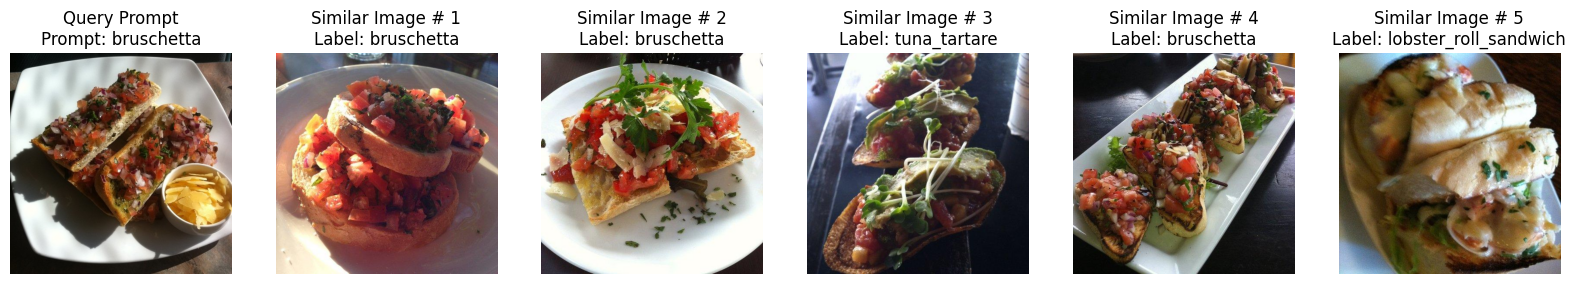

In [59]:
images = []; labels = []

for id, label in zip(sim_image_ids, sim_image_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

images.insert(0, test_sample)
labels.insert(0, id2label[test_label])
plot_images(images, labels)